# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

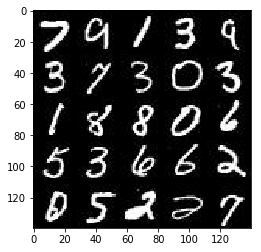

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

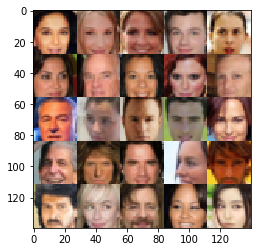

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, alpha):
    return tf.maximum(alpha * x, x)

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        # images = 28x28x3 or 28x28x1
        
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = leaky_relu(x1, alpha=alpha)
        # now 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2, alpha=alpha)
        # now 7x7x128
    
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3, alpha=alpha)
        # now 4x4x256
        
        flat = tf.reshape(relu3, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):
        x0 = tf.layers.dense(z, 7*7*256)
        x0 = tf.reshape(x0, [-1, 7, 7, 256])
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = leaky_relu(x0, alpha=alpha)
        # now 7x7x256
        
        x1 = tf.layers.conv2d_transpose(x0, 128, 4, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1, alpha=alpha)
        # now 14x14x128
    
        x2 = tf.layers.conv2d_transpose(x1, 64, 4, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2, alpha=alpha)
        # now 28x28x64
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 4, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          print_every=20, show_every = 100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_dim = data_shape[-1]
    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1=0.5)
    
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # normalize the images -1 to 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, out_dim, data_image_mode)
                    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 1.3503
Epoch 1/2... Discriminator Loss: 1.8874... Generator Loss: 0.2829
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 1.5522
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.7418
Epoch 1/2... Discriminator Loss: 1.3474... Generator Loss: 0.6440


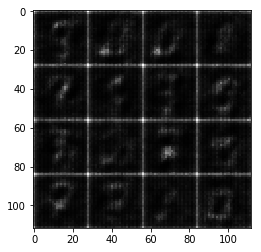

Epoch 1/2... Discriminator Loss: 1.5117... Generator Loss: 0.4638
Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 0.8338
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 0.9875
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 0.6008
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 0.8712


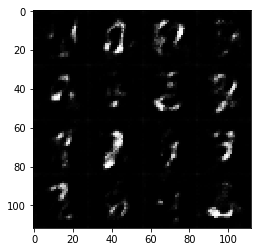

Epoch 1/2... Discriminator Loss: 1.1108... Generator Loss: 0.7268
Epoch 1/2... Discriminator Loss: 0.8759... Generator Loss: 1.2133
Epoch 1/2... Discriminator Loss: 0.8248... Generator Loss: 1.2509
Epoch 1/2... Discriminator Loss: 0.8788... Generator Loss: 1.0898
Epoch 1/2... Discriminator Loss: 0.8123... Generator Loss: 1.2018


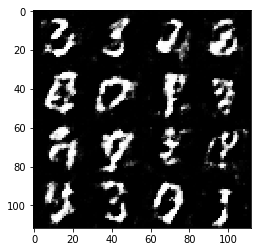

Epoch 1/2... Discriminator Loss: 0.8401... Generator Loss: 1.6125
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 0.8224
Epoch 1/2... Discriminator Loss: 1.6105... Generator Loss: 0.4948
Epoch 1/2... Discriminator Loss: 0.8930... Generator Loss: 1.0696
Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 0.6016


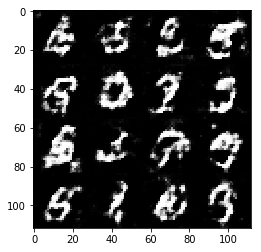

Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.5566
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 1.0793
Epoch 1/2... Discriminator Loss: 1.0564... Generator Loss: 1.2963
Epoch 1/2... Discriminator Loss: 1.0439... Generator Loss: 1.6935
Epoch 1/2... Discriminator Loss: 0.9688... Generator Loss: 1.0561


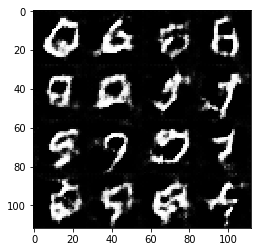

Epoch 1/2... Discriminator Loss: 1.1653... Generator Loss: 0.6998
Epoch 1/2... Discriminator Loss: 0.9981... Generator Loss: 0.9191
Epoch 1/2... Discriminator Loss: 0.9963... Generator Loss: 1.3522
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 0.5391
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 1.4795


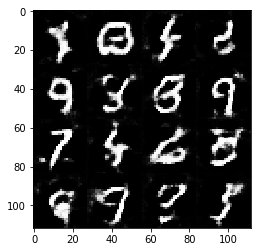

Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 0.9660... Generator Loss: 1.5335
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 0.8541
Epoch 1/2... Discriminator Loss: 0.9016... Generator Loss: 1.0439
Epoch 1/2... Discriminator Loss: 0.9685... Generator Loss: 1.2553


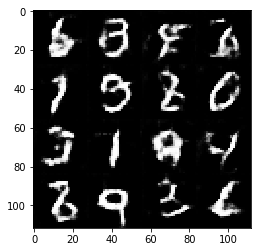

Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 0.8204
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.6550
Epoch 1/2... Discriminator Loss: 1.0253... Generator Loss: 0.8533
Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 0.5504
Epoch 1/2... Discriminator Loss: 0.9893... Generator Loss: 1.5439


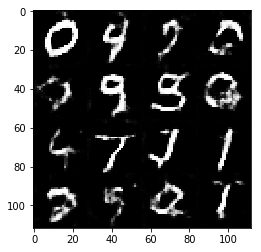

Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 1.3095
Epoch 1/2... Discriminator Loss: 1.0411... Generator Loss: 0.9343
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 0.8198
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 1.4605
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.5443


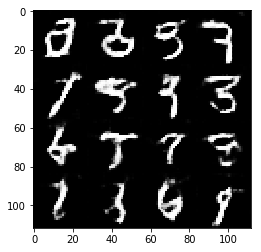

Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 0.7424
Epoch 1/2... Discriminator Loss: 0.9203... Generator Loss: 1.0235
Epoch 1/2... Discriminator Loss: 0.9418... Generator Loss: 1.1267
Epoch 1/2... Discriminator Loss: 0.8346... Generator Loss: 1.7754
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 0.9730


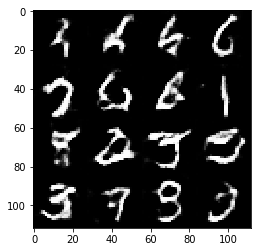

Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 1.1290
Epoch 1/2... Discriminator Loss: 1.0603... Generator Loss: 0.8042
Epoch 1/2... Discriminator Loss: 1.0418... Generator Loss: 0.8173
Epoch 1/2... Discriminator Loss: 0.8815... Generator Loss: 1.1580
Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 0.5800


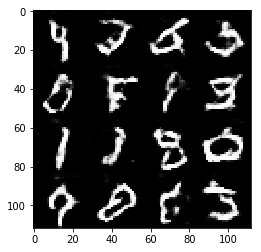

Epoch 1/2... Discriminator Loss: 0.8826... Generator Loss: 1.1064
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 0.9705
Epoch 1/2... Discriminator Loss: 1.0850... Generator Loss: 0.7880
Epoch 1/2... Discriminator Loss: 0.9022... Generator Loss: 1.6493
Epoch 1/2... Discriminator Loss: 0.7085... Generator Loss: 1.4500


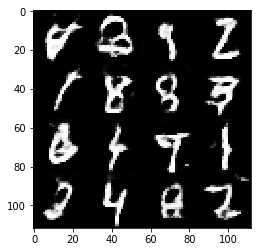

Epoch 1/2... Discriminator Loss: 0.8197... Generator Loss: 1.0784
Epoch 1/2... Discriminator Loss: 0.8998... Generator Loss: 2.0942
Epoch 1/2... Discriminator Loss: 0.7710... Generator Loss: 1.3038
Epoch 1/2... Discriminator Loss: 0.7587... Generator Loss: 1.6920
Epoch 1/2... Discriminator Loss: 0.7703... Generator Loss: 1.2642


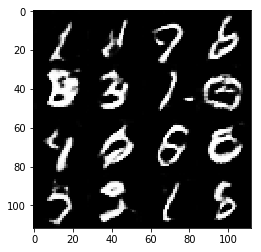

Epoch 1/2... Discriminator Loss: 0.8539... Generator Loss: 1.5025
Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 0.7689
Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 1.0862
Epoch 1/2... Discriminator Loss: 0.8718... Generator Loss: 1.0395
Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 1.7342


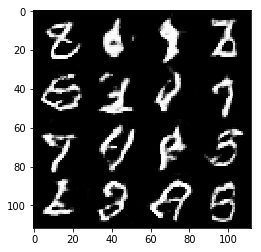

Epoch 1/2... Discriminator Loss: 0.6128... Generator Loss: 1.7864
Epoch 1/2... Discriminator Loss: 1.3798... Generator Loss: 0.5571
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.5852
Epoch 1/2... Discriminator Loss: 0.8637... Generator Loss: 1.1657
Epoch 1/2... Discriminator Loss: 0.6691... Generator Loss: 1.5289


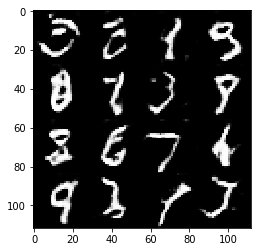

Epoch 1/2... Discriminator Loss: 0.8177... Generator Loss: 1.0867
Epoch 1/2... Discriminator Loss: 0.7741... Generator Loss: 1.2540
Epoch 1/2... Discriminator Loss: 0.6733... Generator Loss: 1.6257
Epoch 1/2... Discriminator Loss: 0.7257... Generator Loss: 1.4961
Epoch 1/2... Discriminator Loss: 0.9595... Generator Loss: 1.2806


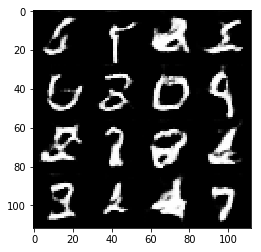

Epoch 1/2... Discriminator Loss: 0.8316... Generator Loss: 1.0910
Epoch 1/2... Discriminator Loss: 0.8355... Generator Loss: 1.0822
Epoch 1/2... Discriminator Loss: 0.7157... Generator Loss: 1.3664
Epoch 1/2... Discriminator Loss: 0.9021... Generator Loss: 1.7736
Epoch 1/2... Discriminator Loss: 0.9447... Generator Loss: 0.9239


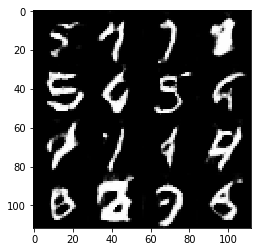

Epoch 1/2... Discriminator Loss: 0.7661... Generator Loss: 1.2642
Epoch 1/2... Discriminator Loss: 0.6889... Generator Loss: 1.8140
Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 1.6326
Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 1.5180
Epoch 1/2... Discriminator Loss: 0.9481... Generator Loss: 0.9321


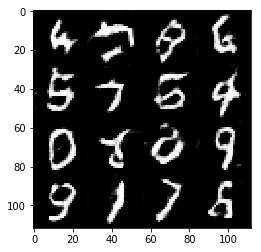

Epoch 1/2... Discriminator Loss: 0.8605... Generator Loss: 1.0282
Epoch 1/2... Discriminator Loss: 0.6781... Generator Loss: 1.5642
Epoch 1/2... Discriminator Loss: 0.5752... Generator Loss: 1.8057
Epoch 2/2... Discriminator Loss: 0.5955... Generator Loss: 1.9723
Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 1.5610


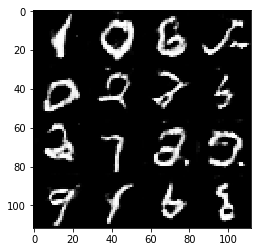

Epoch 2/2... Discriminator Loss: 0.5749... Generator Loss: 1.9797
Epoch 2/2... Discriminator Loss: 0.6372... Generator Loss: 1.7536
Epoch 2/2... Discriminator Loss: 0.5582... Generator Loss: 1.9477
Epoch 2/2... Discriminator Loss: 0.6657... Generator Loss: 1.5156
Epoch 2/2... Discriminator Loss: 0.7254... Generator Loss: 1.4429


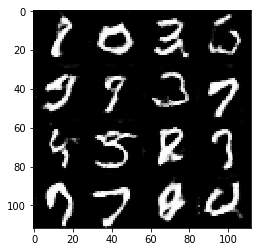

Epoch 2/2... Discriminator Loss: 0.5856... Generator Loss: 2.8941
Epoch 2/2... Discriminator Loss: 0.6886... Generator Loss: 1.9614
Epoch 2/2... Discriminator Loss: 0.7797... Generator Loss: 1.1616
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 1.2148
Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 0.7994


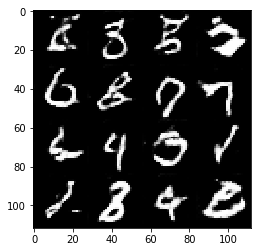

Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.1074
Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 1.1708
Epoch 2/2... Discriminator Loss: 1.0264... Generator Loss: 0.8387
Epoch 2/2... Discriminator Loss: 0.7541... Generator Loss: 1.2631
Epoch 2/2... Discriminator Loss: 0.7223... Generator Loss: 1.4081


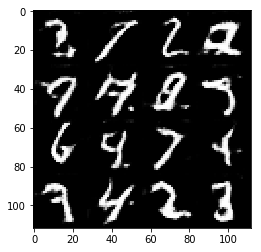

Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 1.1119
Epoch 2/2... Discriminator Loss: 0.5518... Generator Loss: 1.7992
Epoch 2/2... Discriminator Loss: 0.7164... Generator Loss: 1.3623
Epoch 2/2... Discriminator Loss: 0.6128... Generator Loss: 1.7865
Epoch 2/2... Discriminator Loss: 0.7623... Generator Loss: 1.4339


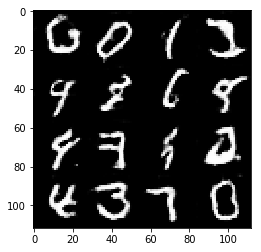

Epoch 2/2... Discriminator Loss: 0.6341... Generator Loss: 1.6217
Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 1.2482
Epoch 2/2... Discriminator Loss: 0.7219... Generator Loss: 1.3933
Epoch 2/2... Discriminator Loss: 0.9142... Generator Loss: 0.9829
Epoch 2/2... Discriminator Loss: 0.5994... Generator Loss: 1.8302


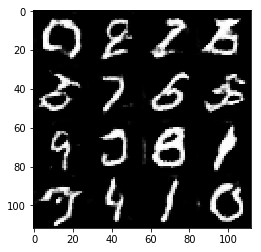

Epoch 2/2... Discriminator Loss: 0.5136... Generator Loss: 2.0001
Epoch 2/2... Discriminator Loss: 0.8651... Generator Loss: 1.1245
Epoch 2/2... Discriminator Loss: 1.0416... Generator Loss: 0.9017
Epoch 2/2... Discriminator Loss: 0.6113... Generator Loss: 2.1901
Epoch 2/2... Discriminator Loss: 0.9453... Generator Loss: 0.9344


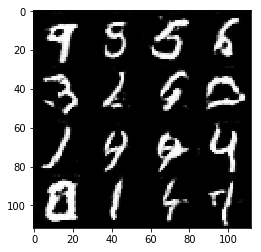

Epoch 2/2... Discriminator Loss: 0.6083... Generator Loss: 1.7317
Epoch 2/2... Discriminator Loss: 0.6196... Generator Loss: 1.8640
Epoch 2/2... Discriminator Loss: 0.7056... Generator Loss: 1.4396
Epoch 2/2... Discriminator Loss: 1.4084... Generator Loss: 0.5416
Epoch 2/2... Discriminator Loss: 0.6408... Generator Loss: 1.6410


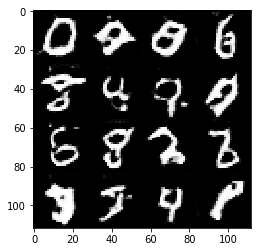

Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 1.3220
Epoch 2/2... Discriminator Loss: 0.5924... Generator Loss: 2.0138
Epoch 2/2... Discriminator Loss: 0.8469... Generator Loss: 1.0935
Epoch 2/2... Discriminator Loss: 0.7001... Generator Loss: 1.4255
Epoch 2/2... Discriminator Loss: 0.6032... Generator Loss: 1.7131


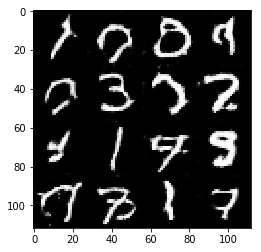

Epoch 2/2... Discriminator Loss: 0.6342... Generator Loss: 1.5408
Epoch 2/2... Discriminator Loss: 0.6610... Generator Loss: 1.5148
Epoch 2/2... Discriminator Loss: 0.6420... Generator Loss: 1.7054
Epoch 2/2... Discriminator Loss: 0.5834... Generator Loss: 1.7162
Epoch 2/2... Discriminator Loss: 0.6136... Generator Loss: 1.9351


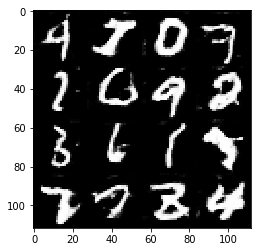

Epoch 2/2... Discriminator Loss: 0.5379... Generator Loss: 2.2400
Epoch 2/2... Discriminator Loss: 0.5903... Generator Loss: 1.6503
Epoch 2/2... Discriminator Loss: 0.7345... Generator Loss: 1.2388
Epoch 2/2... Discriminator Loss: 0.4419... Generator Loss: 2.6117
Epoch 2/2... Discriminator Loss: 0.6772... Generator Loss: 1.6138


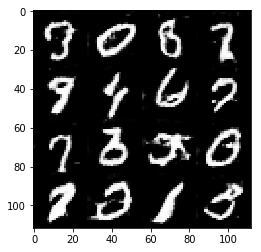

Epoch 2/2... Discriminator Loss: 0.5975... Generator Loss: 1.7825
Epoch 2/2... Discriminator Loss: 0.5529... Generator Loss: 1.8477
Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 1.9904
Epoch 2/2... Discriminator Loss: 0.5768... Generator Loss: 2.1973
Epoch 2/2... Discriminator Loss: 0.5527... Generator Loss: 2.1287


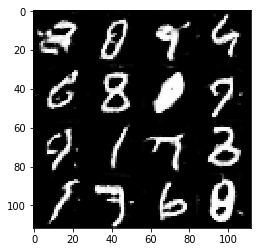

Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 0.9714
Epoch 2/2... Discriminator Loss: 0.7671... Generator Loss: 1.2670
Epoch 2/2... Discriminator Loss: 0.8024... Generator Loss: 1.1657
Epoch 2/2... Discriminator Loss: 0.6325... Generator Loss: 1.6141
Epoch 2/2... Discriminator Loss: 0.5016... Generator Loss: 2.0347


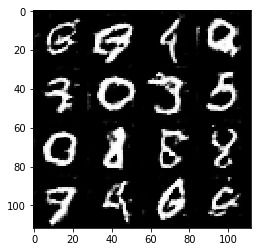

Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 0.5895... Generator Loss: 1.7305
Epoch 2/2... Discriminator Loss: 0.5525... Generator Loss: 1.8424
Epoch 2/2... Discriminator Loss: 0.5694... Generator Loss: 2.6435
Epoch 2/2... Discriminator Loss: 0.6323... Generator Loss: 1.8686


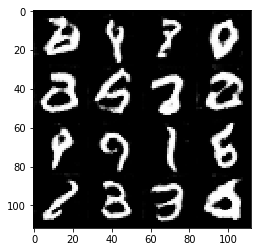

Epoch 2/2... Discriminator Loss: 0.9329... Generator Loss: 0.9024
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.3444
Epoch 2/2... Discriminator Loss: 0.6697... Generator Loss: 1.3558
Epoch 2/2... Discriminator Loss: 0.5650... Generator Loss: 1.9271
Epoch 2/2... Discriminator Loss: 0.7017... Generator Loss: 1.4119


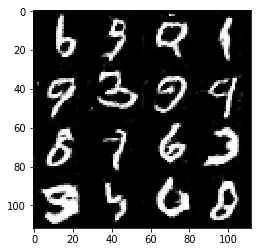

Epoch 2/2... Discriminator Loss: 1.4036... Generator Loss: 0.5554
Epoch 2/2... Discriminator Loss: 0.6175... Generator Loss: 1.7823
Epoch 2/2... Discriminator Loss: 0.5851... Generator Loss: 2.1502
Epoch 2/2... Discriminator Loss: 0.6114... Generator Loss: 1.8490
Epoch 2/2... Discriminator Loss: 0.4850... Generator Loss: 2.3011


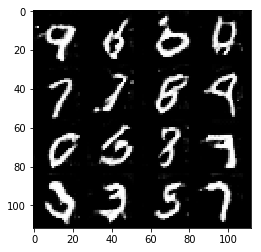

Epoch 2/2... Discriminator Loss: 0.6057... Generator Loss: 1.6298
Epoch 2/2... Discriminator Loss: 0.5798... Generator Loss: 1.7591
Epoch 2/2... Discriminator Loss: 0.6174... Generator Loss: 1.5922
Epoch 2/2... Discriminator Loss: 0.6786... Generator Loss: 1.4490
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 1.5459


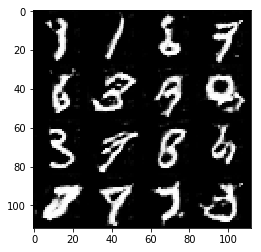

Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.5363
Epoch 2/2... Discriminator Loss: 0.7596... Generator Loss: 1.3031
Epoch 2/2... Discriminator Loss: 0.7609... Generator Loss: 1.2163
Epoch 2/2... Discriminator Loss: 0.5255... Generator Loss: 2.3438
Epoch 2/2... Discriminator Loss: 0.5256... Generator Loss: 2.2903


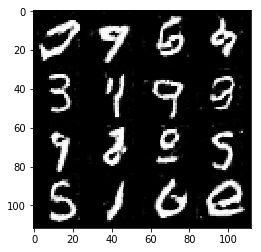

Epoch 2/2... Discriminator Loss: 0.5595... Generator Loss: 1.7994
Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 0.9706
Epoch 2/2... Discriminator Loss: 0.5842... Generator Loss: 1.8316
Epoch 2/2... Discriminator Loss: 0.8888... Generator Loss: 1.0070
Epoch 2/2... Discriminator Loss: 0.6652... Generator Loss: 1.4209


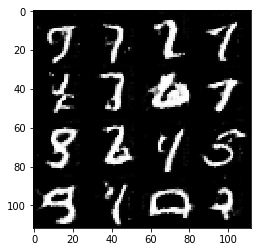

Epoch 2/2... Discriminator Loss: 1.0857... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 1.0176... Generator Loss: 0.9355


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.1588
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 1.1285


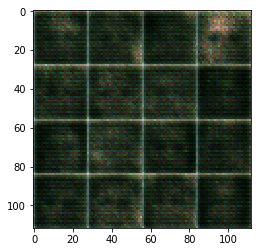

Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.6396
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 1.4204
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 0.5658... Generator Loss: 2.1005
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 1.0971


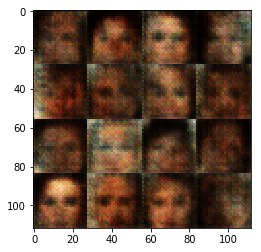

Epoch 1/1... Discriminator Loss: 0.6653... Generator Loss: 1.8089
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 1.1826
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.9071


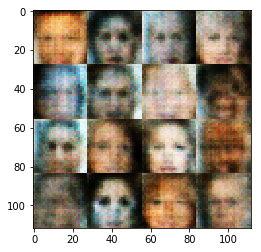

Epoch 1/1... Discriminator Loss: 0.6090... Generator Loss: 2.3790
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.1907
Epoch 1/1... Discriminator Loss: 0.8633... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 1.4027
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.7489


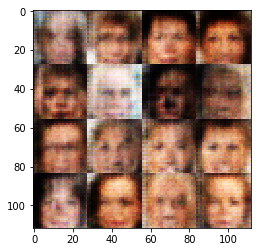

Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.5547... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.8633


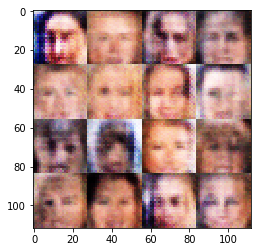

Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 1.0975
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.7627


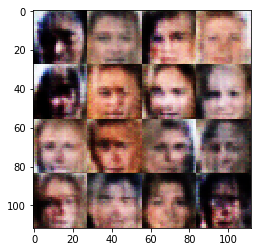

Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 1.4736
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.2249
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.7918
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.2299
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.2988


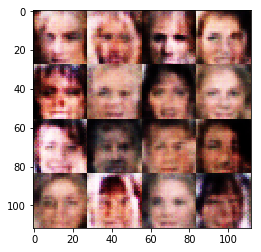

Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.2386
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.8783


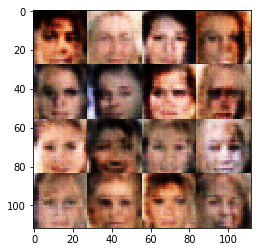

Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 1.5186
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 1.6075
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 2.5326
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 1.6030
Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 2.4273


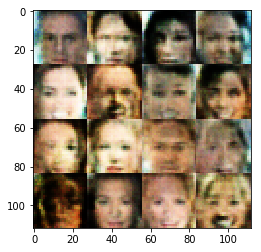

Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.2168
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 0.9777


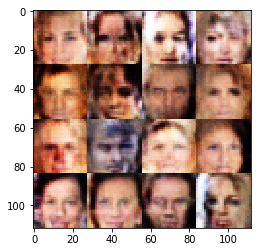

Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 2.0612
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.0813
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.7284


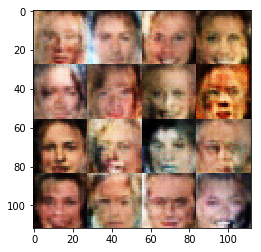

Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 2.4047
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 2.1923
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 2.0103
Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 1.5291


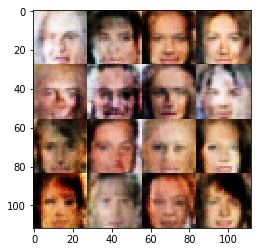

Epoch 1/1... Discriminator Loss: 0.5653... Generator Loss: 2.0090
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 4.0212
Epoch 1/1... Discriminator Loss: 0.6810... Generator Loss: 1.5515
Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 2.1193
Epoch 1/1... Discriminator Loss: 0.4836... Generator Loss: 2.6402


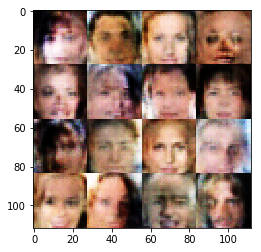

Epoch 1/1... Discriminator Loss: 0.4629... Generator Loss: 2.8397
Epoch 1/1... Discriminator Loss: 0.4668... Generator Loss: 2.3800
Epoch 1/1... Discriminator Loss: 0.6180... Generator Loss: 5.6712
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 1.6854
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6085


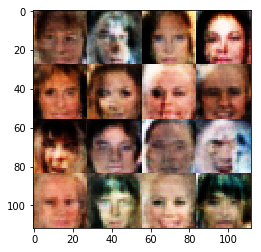

Epoch 1/1... Discriminator Loss: 0.4894... Generator Loss: 2.7560
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.6076
Epoch 1/1... Discriminator Loss: 0.7289... Generator Loss: 3.1398
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 3.4727


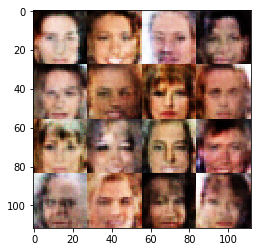

Epoch 1/1... Discriminator Loss: 0.4748... Generator Loss: 2.4453
Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.6489
Epoch 1/1... Discriminator Loss: 0.4233... Generator Loss: 3.5982
Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 2.7388
Epoch 1/1... Discriminator Loss: 0.7729... Generator Loss: 1.2582


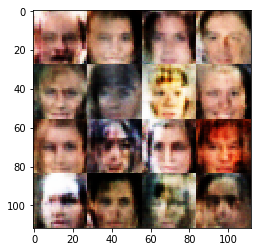

Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 1.5175
Epoch 1/1... Discriminator Loss: 0.4724... Generator Loss: 2.2975
Epoch 1/1... Discriminator Loss: 0.4388... Generator Loss: 2.6116
Epoch 1/1... Discriminator Loss: 0.3891... Generator Loss: 3.5182
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 4.0845


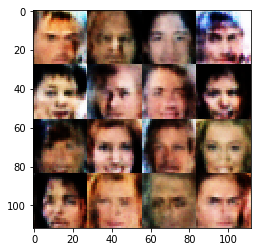

Epoch 1/1... Discriminator Loss: 0.3974... Generator Loss: 4.2314
Epoch 1/1... Discriminator Loss: 0.7260... Generator Loss: 1.2541
Epoch 1/1... Discriminator Loss: 0.5501... Generator Loss: 4.6463
Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 2.9172
Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 4.0586


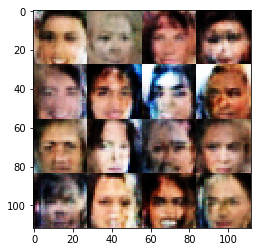

Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 2.8974
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 4.6617
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 3.2157
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 2.8226


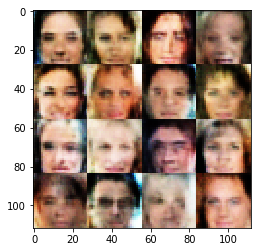

Epoch 1/1... Discriminator Loss: 0.4308... Generator Loss: 3.1689
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 2.5399
Epoch 1/1... Discriminator Loss: 0.4322... Generator Loss: 2.5657


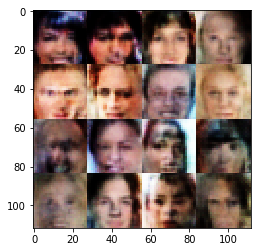

Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 4.2380
Epoch 1/1... Discriminator Loss: 0.3933... Generator Loss: 4.9945
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 1.9944
Epoch 1/1... Discriminator Loss: 0.5483... Generator Loss: 1.8893
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 2.4114


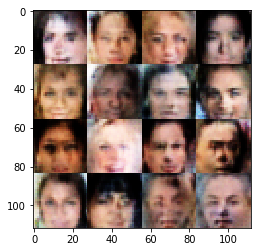

Epoch 1/1... Discriminator Loss: 0.5488... Generator Loss: 1.8471
Epoch 1/1... Discriminator Loss: 0.5606... Generator Loss: 1.8261
Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 1.2833
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 2.4978


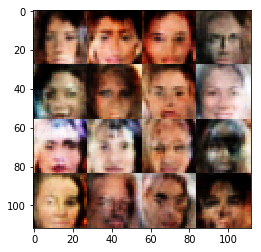

Epoch 1/1... Discriminator Loss: 0.4445... Generator Loss: 4.1610
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 5.3147
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 0.3961... Generator Loss: 3.2143
Epoch 1/1... Discriminator Loss: 0.4643... Generator Loss: 2.3603


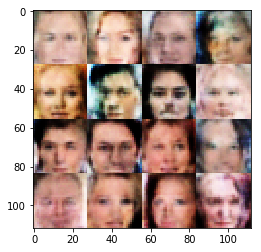

Epoch 1/1... Discriminator Loss: 0.3685... Generator Loss: 3.9944
Epoch 1/1... Discriminator Loss: 0.4646... Generator Loss: 3.9961
Epoch 1/1... Discriminator Loss: 0.4327... Generator Loss: 2.6013
Epoch 1/1... Discriminator Loss: 0.3468... Generator Loss: 6.1916
Epoch 1/1... Discriminator Loss: 0.5337... Generator Loss: 2.0569


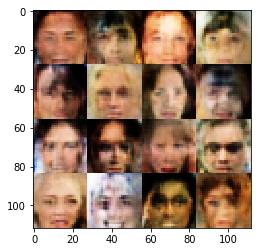

Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 2.6757
Epoch 1/1... Discriminator Loss: 0.4728... Generator Loss: 2.2342
Epoch 1/1... Discriminator Loss: 0.4279... Generator Loss: 2.6673
Epoch 1/1... Discriminator Loss: 0.4888... Generator Loss: 2.1874
Epoch 1/1... Discriminator Loss: 0.3767... Generator Loss: 3.8759


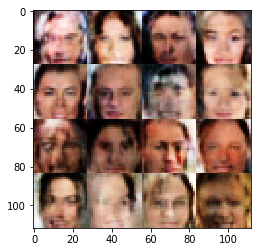

Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 3.8515
Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 3.4221
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 3.3648
Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 2.6907
Epoch 1/1... Discriminator Loss: 0.3659... Generator Loss: 3.9583


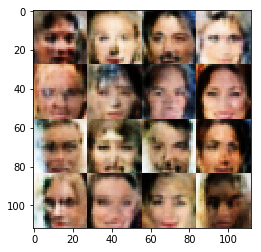

Epoch 1/1... Discriminator Loss: 0.3632... Generator Loss: 4.0191
Epoch 1/1... Discriminator Loss: 0.3427... Generator Loss: 5.3278
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 0.4111... Generator Loss: 2.9080
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 1.7913


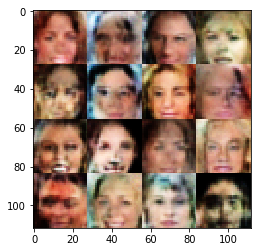

Epoch 1/1... Discriminator Loss: 1.7576... Generator Loss: 0.3857
Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 3.5086
Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 5.0571
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 3.1436
Epoch 1/1... Discriminator Loss: 0.3608... Generator Loss: 4.1411


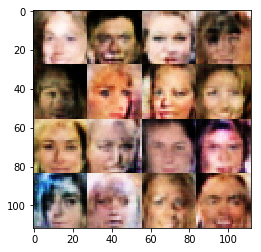

Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 1.3999
Epoch 1/1... Discriminator Loss: 0.3928... Generator Loss: 3.6525
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.6367
Epoch 1/1... Discriminator Loss: 0.4780... Generator Loss: 2.2605
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 2.6455


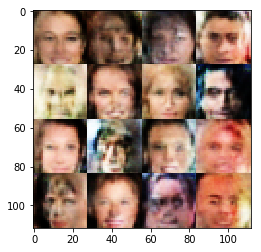

Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 3.2823
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 3.5618
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 2.3476
Epoch 1/1... Discriminator Loss: 0.5217... Generator Loss: 2.7104
Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 4.1220


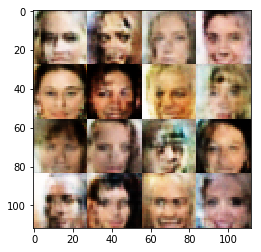

Epoch 1/1... Discriminator Loss: 0.4366... Generator Loss: 2.7606
Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 4.2435
Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 4.0876
Epoch 1/1... Discriminator Loss: 0.3646... Generator Loss: 4.3868
Epoch 1/1... Discriminator Loss: 0.3891... Generator Loss: 5.5995


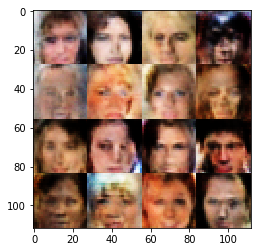

Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 5.8354
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 3.3117
Epoch 1/1... Discriminator Loss: 0.4183... Generator Loss: 3.2416
Epoch 1/1... Discriminator Loss: 0.5737... Generator Loss: 2.2425
Epoch 1/1... Discriminator Loss: 0.3396... Generator Loss: 5.5648


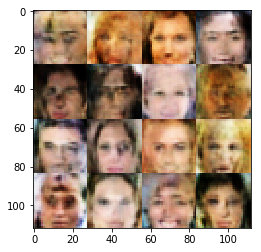

Epoch 1/1... Discriminator Loss: 0.3578... Generator Loss: 4.6424
Epoch 1/1... Discriminator Loss: 0.4883... Generator Loss: 2.4811
Epoch 1/1... Discriminator Loss: 0.3654... Generator Loss: 4.1475
Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 1.7578
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.9611


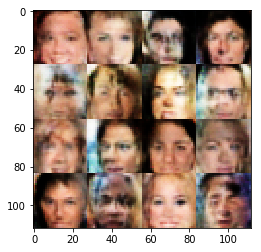

Epoch 1/1... Discriminator Loss: 0.3702... Generator Loss: 5.5353
Epoch 1/1... Discriminator Loss: 0.4447... Generator Loss: 2.7216
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 3.9053
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 2.5616


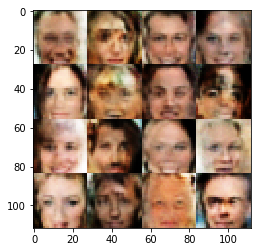

Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 3.7574
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 3.0987
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 2.4553
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 0.3771... Generator Loss: 3.8782


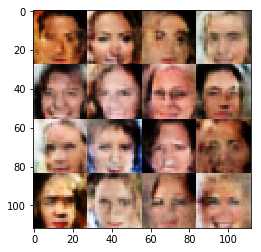

Epoch 1/1... Discriminator Loss: 0.3661... Generator Loss: 4.0341
Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 5.0850
Epoch 1/1... Discriminator Loss: 0.3458... Generator Loss: 5.5491
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 3.7267
Epoch 1/1... Discriminator Loss: 0.3870... Generator Loss: 4.0906


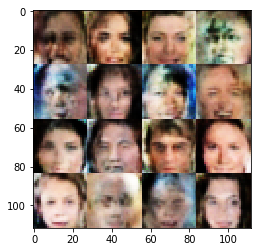

Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 4.0579
Epoch 1/1... Discriminator Loss: 1.7036... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 6.1239
Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 7.6866
Epoch 1/1... Discriminator Loss: 0.4032... Generator Loss: 4.1697


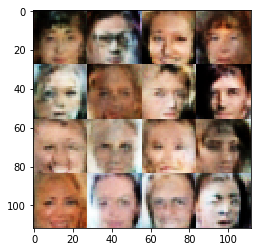

Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 3.5886
Epoch 1/1... Discriminator Loss: 0.3553... Generator Loss: 6.2340
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 0.4957... Generator Loss: 2.0748
Epoch 1/1... Discriminator Loss: 0.3569... Generator Loss: 3.9690


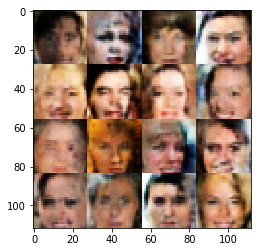

Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 5.1917
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 5.4744
Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 3.4974
Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 2.5036
Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 1.4125


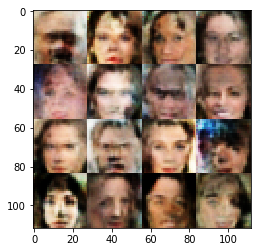

Epoch 1/1... Discriminator Loss: 0.3680... Generator Loss: 4.1028
Epoch 1/1... Discriminator Loss: 1.8806... Generator Loss: 3.2498
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 0.3743... Generator Loss: 3.8931
Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 1.3131


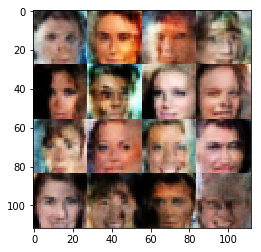

Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 6.6018
Epoch 1/1... Discriminator Loss: 0.4170... Generator Loss: 3.4590
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 2.9430
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 1.8282
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 2.3335


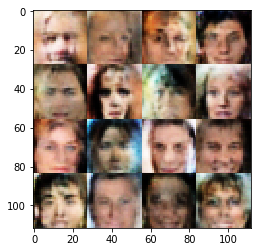

Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 3.9824
Epoch 1/1... Discriminator Loss: 0.4930... Generator Loss: 2.5869
Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 3.8148
Epoch 1/1... Discriminator Loss: 0.4173... Generator Loss: 3.3851


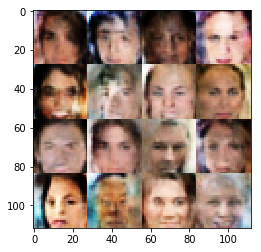

Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 1.9338
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 3.2866
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 4.7034
Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 1.7233
Epoch 1/1... Discriminator Loss: 0.4386... Generator Loss: 2.5278


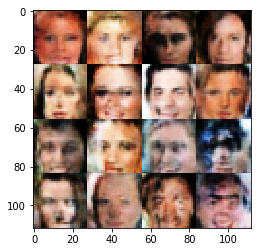

Epoch 1/1... Discriminator Loss: 0.5112... Generator Loss: 5.9413


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.